# Visualize Systematic Shifts with t-SNE
Given the config from a shift experiment as well as its outputs (.tsv files of pair dists and clusters), this notebook visualizes shift clusters as 2D images.

In [5]:
import utils
import eval_utils
import numpy as np
from SpacePair import SpacePair
import exp_unsup
import time

from pandas import DataFrame

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Dict, Tuple

#### Functions for Data Preparation and Plotting

In [6]:
# select the vectors to visualize
def select_vectors_by_ID(df, idx, sp, PX):
    cluster = df.iloc[idx]
    wordpairs = eval_utils.jointhem(cluster["cluster_words"], may_be_pairs=tuples).split(', ')[:100]
    labels    = eval_utils.jointhem(cluster["direction_label"], may_be_pairs=False).split(', ')[:3]
    centroid  = eval_utils.jointhem(cluster["centroid"], may_be_pairs=tuples).split('--')
    
    src_words, trg_words = list(zip(*[(t,t) if len(t.split('--'))==1 
                                            else tuple(t.split('--')) 
                                            for t in wordpairs]))
    # index of the cluster centroid within the list of selected vectors
    c_idx = src_words.index(centroid[0])

    selected_PX  = np.array([  PX[sp.voc_x[u]] for u in src_words])
    selected_Y   = np.array([sp.Y[sp.voc_y[v]] for v in trg_words])
    selected_lbl = np.array([sp.Y[sp.voc_y[w]] for w in labels])
    
    return [selected_PX, selected_Y, selected_lbl, src_words, trg_words, labels, c_idx]

def single_cluster_outstring(t, indices, y, e):
    # Simply creates a unique output destination
    if type(indices) == int:
        indices = [indices]
    result = "visuals/tsne/tsne_"+y[:-1]+"_"+e[:-1]\
             +"_"+str(t[3][t[6]])+"_"\
             +"-".join([str(i) for i in indices])\
             +"_"+str(time.time())[-5:]+".png"
    return result

#============

def tsne_multiple_clusters(*args):
    tsne = TSNE()
    reduced_points = tsne.fit_transform(np.concatenate(args))
    
    separated_reduced = []
    start = 0
    for space in args:
        separated_reduced.append(reduced_points[start:start+space.shape[0]])
        start+=space.shape[0]
        
    return tuple(separated_reduced)

def label_points(coords, labels, ax, distance=(0.5,0.5)):
    for (x,y),l in zip(coords, labels):
        ax.text(x+distance[0], y+distance[1], l)
        
def draw_shifts(start_coords, end_coords, ax, color="black", label=""):
    for (x1,y1),(x2,y2) in zip(start_coords, end_coords):
        ax.plot([x1,x2],[y1,y2], color=color, label=label)

def draw_cluster_labels(coords, labels, ax, text=True, distance=(0.5,0.5), color="forestgreen"):
    
    for point,l in zip(coords, labels):
        x,y = point[0], point[1]
        ax.plot([0,x],[0,y], color=color)
        if text is True:
            ax.text(x+distance[0], y+distance[1], l) 

def visualize_cluster(love_is_all_you_need, ax, 
                      colors=None, names=None, xlabel=True, distance=(0,0), mono=False):
    """
    :param love_is_all_you_need: 7-tuple:
                                 all vectors to visualize (PX, Y, label vectors), 
                                 the corresponding word lists (3x), the ID of the centroid.
    :param mono: if True, the shift labels will only be put to the source vectors (and not to the target ones)
    :param distance: distance of point label position to its point
    """
    PX, Y, L, src_w, trg_w, labels, centroid_idx = love_is_all_you_need
    
    if colors is None: colors=("mediumblue", "deepskyblue", "green",       "orangered", "black") 
    if names is None:  names = ("start",     "end",         "labels in Y", "exemplar",  "shift")
    
    sns.scatterplot(PX[:,0], PX[:,1], color=colors[0], s=shiftpoint_size, ax=ax, label=names[0])
    label_points(PX, src_w, ax, distance=distance)

    sns.scatterplot(Y[:,0],  Y[:,1], color=colors[1], s=shiftpoint_size, ax=ax, label=names[1])
    if mono is False:
        label_points(Y, trg_w, ax, distance=distance)

    sns.scatterplot(L[:,0],  L[:,1], color=colors[2], s=shiftpoint_size, ax=ax, label=names[2])

    draw_shifts(PX, Y, ax, color=colors[4])
    ax.plot([],color=colors[4], label=names[4])
    draw_shifts([PX[centroid_idx]], [Y[centroid_idx]], ax, color=colors[3], label=names[3])
    draw_cluster_labels(L, labels, ax, color=colors[2], distance=distance)
    
    if xlabel is True: 
        ax.set_xlabel("exemplar: "+src_w[centroid_idx]+" — "+trg_w[centroid_idx])
    ax.legend(loc='lower right')
    
    return ax

## Load Data 
In order to work with the shifts, they need to be re-created.
For this, I load the space pair (X, Y, P etc.) and the experiment output.

In [7]:
# Load space pairs from the configs in the experiment outputs
# This is the same as in eval_shift_experiments.ipynb

d1 = "outputs/shift_experiments_apshifts/"
d2 = "outputs/shift_experiments_apsource/"
d3 = "outputs/shift_experiments_noalign_apshifts/"
d4 = "outputs/shift_experiments_noalign_apsource/"

y1 = "1740_1770/"
y2 = "1860_1890/"

e1 = "unsup_bi/"
e2 = "unsup_mono/"
e3 = "dis_tech/"

s1 = "all"
s2 = "all_discourse"
s3 = "all_technical"

          # unsup_bi        # unsup_mono      # discourse       # technical
combos = [(d1, y1, e1, s1), (d1, y1, e2, s1), (d1, y1, e3, s2), (d1, y1, e3, s3),  # 1740 APshifts
          (d1, y2, e1, s1), (d1, y2, e2, s1), (d1, y2, e3, s2), (d1, y2, e3, s3),  # 1860 APshifts         
                            (d3, y2, e2, s1), (d3, y2, e3, s2), (d3, y2, e3, s3),  # noalign APshifts
         ]

#### Watch out, loading the SpacePair is memory-intensive!

In [8]:
d, y, e, s = (d1, y2, e3, s2) # set this with one of the tuples from above

tuples = True if e==e1 or e==e2 else False   # true for unsup_bi and unsup_mono

# read data frames
stats, df_dist, df_clust = eval_utils.read_results(d + y + e, s, e, tuples=tuples, with_baseline=False)

# load space pair and project X onto Y
sp = SpacePair.from_config(d+y+"spacepair.cfg", init_all=True)
PX = np.array([sp.P.dot(x) for x in sp.X])

lines: 0it [00:00, ?it/s]

loading space from /home/simon/Desktop/thesis/GWOT/data/vectors1929-init-tc1-t3/rsc-all-corr-186.txt ...


lines: 183156it [00:03, 55927.58it/s]
lines: 4762it [00:00, 47617.77it/s]

loading space from /home/simon/Desktop/thesis/GWOT/data/vectors1929-init-tc1-t3/rsc-all-corr-189.txt ...


lines: 183156it [00:03, 50741.31it/s]
reading frequencies: 462166it [00:00, 500792.27it/s]


Initializing Gromov-Wasserstein Aligners ...
Initializing coupling instance.
loading pre-trained coupling from: 
   outputs/large_couplings/1860_1890/ ...
   estimating p and q based on the coupling ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation
Initializing coupling instance.
loading pre-trained coupling from: 
   outputs/small_couplings/1860_1890/ ...
   estimating p and q based on the coupling ...
Initializing Gromov-Wasserstein optimizer
*NOT* Using GPU in Gromov-Wasserstein computation

Trying to get T and P (translation pairs and projection matrix) ...
Finding orthogonal mapping with 100 anchor points


#### Load the .tsv data, make shift vectors etc.

In [9]:
# extract word pairs from df_dist and make difference vectors
try:
    pairs = [(w1, w2) for w1, w2 in zip(df_dist["src_word"].tolist(), df_dist["trg_word"].tolist())]
except KeyError:
    pairs = [(w, w) for w in df_dist["word"].tolist()] # for the dis_tech experiment

from_vecs = np.array([  PX[sp.voc_x[u]] for u,_ in pairs])
to_vecs   = np.array([sp.Y[sp.voc_y[v]] for _,v in pairs])
D = utils.shift_directions(from_vecs, to_vecs, norm=False) # norm the vectors
D = exp_unsup.normalize_shifts_by_frequency(D, pairs, sp.freq_x, sp.freq_y)
voc_D = {p: i for i, p in enumerate(pairs)}
ind_D = {i: p for i, p in enumerate(pairs)}

/home/simon/Desktop/thesis/GWOT/exp_unsup.py:169: RuntimeWarning: divide by zero encountered in log
  norms = np.array([max(np.log(abs(freq2[w2]-freq1[w1])),1) for w1,w2 in sorted_pairs])


### Optionally, for the DisTech experiments: Load the 'technical' clusters in parallel

In [10]:
     # discourse       # technical
_ = [(d1, y1, e3, s2), (d1, y1, e3, s3),  # 1740 APshifts
     (d1, y2, e3, s2), (d1, y2, e3, s3),  # 1860 APshifts         
     (d3, y2, e3, s2), (d3, y2, e3, s3),  # noalign APshifts
    ]

# All the variables basically have a _tec suffix

dtec, ytec, etec, stec = (d1, y2, e3, s3) # set this tuple

stats_tec, df_dist_tec, df_clust_tec = eval_utils.read_results(dtec + ytec + etec, 
                                                               stec, etec, 
                                                               tuples=tuples, with_baseline=False)
# extract word pairs from df_dist and make difference vectors
try:
    pairs_tec = [(w1, w2) for w1, w2 in zip(df_dist_tec["src_word"].tolist(), df_dist_tec["trg_word"].tolist())]
except KeyError:
    pairs_tec = [(w, w) for w in df_dist["word"].tolist()] # for the dis_tech experiment

from_vecs_tec = np.array([  PX[sp.voc_x[u]] for u,_ in pairs_tec])
to_vecs_tec   = np.array([sp.Y[sp.voc_y[v]] for _,v in pairs_tec])
D_tec = utils.shift_directions(from_vecs_tec, to_vecs_tec, norm=False) # norm the vectors
D_tec = exp_unsup.normalize_shifts_by_frequency(D_tec, pairs_tec, sp.freq_x, sp.freq_y)
voc_D_tec = {p: i for i, p in enumerate(pairs_tec)}
ind_D_tec = {i: p for i, p in enumerate(pairs_tec)}

## Visualize a single cluster

In [11]:
cluster_id = 110    # choose this
frame = df_clust    # ... and maybe this, if you're dealing with df_clust_tec


tup = select_vectors_by_ID(frame, cluster_id, sp, PX)
tup[0],tup[1],tup[2] = tsne_multiple_clusters(tup[0], tup[1], tup[2]) # this is where the magic happens

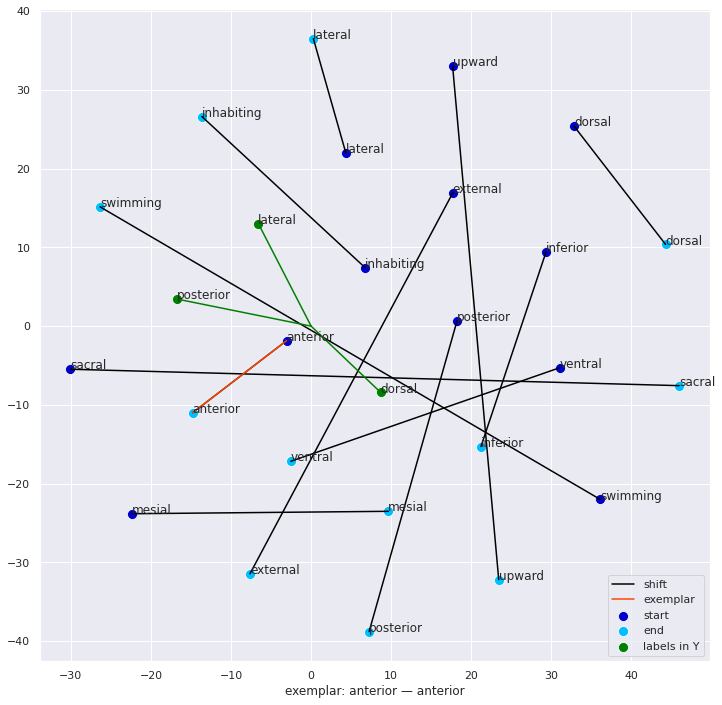

In [25]:
sns.set()
size_factor = 12
fig, ax = plt.subplots(1, 1, figsize=(size_factor, size_factor))

visualize_cluster(tup, ax, mono=tuples)

In [27]:
outstring = single_cluster_outstring(tup, cluster_id, y, e)
print(outstring)
#fig.savefig(outstring, dpi=250)

visuals/tsne/tsne_1860_1890_dis_tech_anterior_110_31182.png


#### Playground: Print out different clusters to see their members etc.

In [29]:
for id in [98]:
    eval_utils.print_by_ID(df_clust, id, tuples=tuples)
    print("")

centroid: accepting (ID: 98)
size:        12     
labels:      assuming, finding, assigning, classifying, granting
members:     accepted, grouping, discovering, believing, adopting, old, overcoming, accepting, asserting, many, rejecting, mistaken




## Visualize 2 Clusters Jointly

In [30]:
i1 = 22 # iron
i2 = 5 # purifying
frame = df_clust_tec

t1 = select_vectors_by_ID(frame, i1, sp, PX)
t2 = select_vectors_by_ID(frame, i2, sp, PX)
t1[0],t1[1],t1[2], t2[0],t2[1],t2[2] = tsne_multiple_clusters( t1[0],t1[1],t1[2], t2[0],t2[1],t2[2])

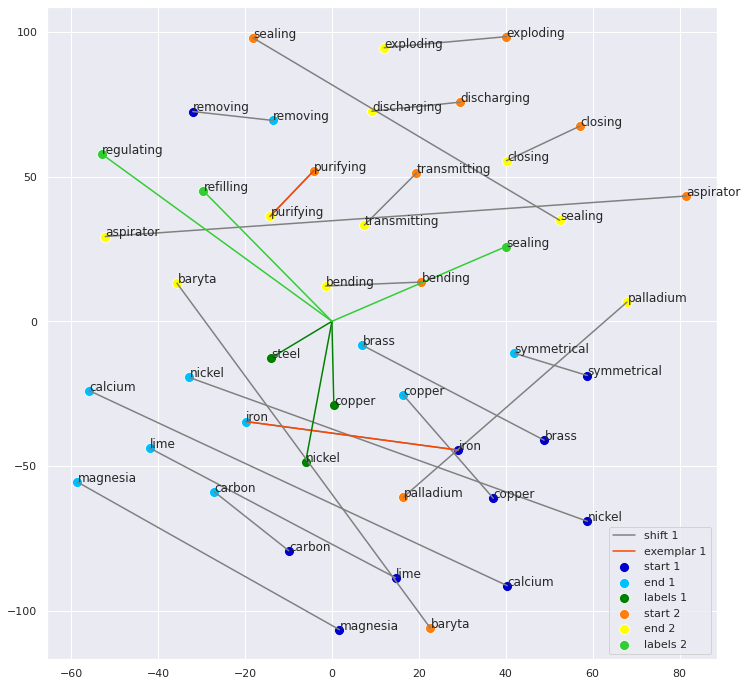

In [31]:
sns.set()
disp = 0.1 # displacement of point label in both directions

size_factor = 12
fig, ax = plt.subplots(rows, columns, figsize=(size_factor, size_factor))

visualize_cluster(t1, ax, xlabel=False, distance=(disp, disp), mono=tuples,
                  colors=("mediumblue", "deepskyblue", "green",    "orangered",  "grey"), 
                  names= ("start 1",    "end 1",       "labels 1", "exemplar 1", "shift 1"))

visualize_cluster(t2, ax, xlabel=False, distance=(disp, disp), mono=tuples,
                  colors=("tab:orange", "yellow", "limegreen", "orangered", "grey"), 
                  names= ("start 2",    "end 2",  "labels 2",   "",         ""))

axes.legend(loc='lower left') # optional

In [32]:
outstring = single_cluster_outstring(t1, [i1, i2], y, e)
print(outstring)
#fig.savefig(outstring, dpi=250)

visuals/tsne/tsne_1860_1890_dis_tech_iron_22-5_07102.png


## Visualize 4 Clusters Jointly

In [33]:
i1 = 81  # seen
i2 = 93  # spreading
i3 = 98  # accepting
i4 = 75  # shorter
frame = df_clust

t1 = select_vectors_by_ID(frame, i1, sp, PX)
t2 = select_vectors_by_ID(frame, i2, sp, PX)
t3 = select_vectors_by_ID(frame, i3, sp, PX)
t4 = select_vectors_by_ID(frame, i4, sp, PX)

t1[0],t1[1],t1[2],    t2[0],t2[1],t2[2],  t3[0],t3[1],t3[2],  t4[0],t4[1],t4[2] = tsne_multiple_clusters(
   t1[0],t1[1],t1[2], t2[0],t2[1],t2[2],  t3[0],t3[1],t3[2],  t4[0],t4[1],t4[2])




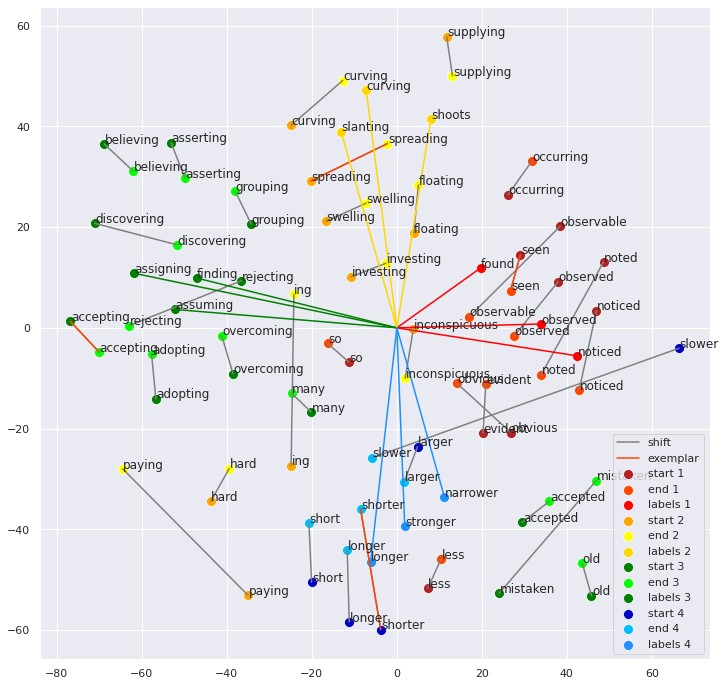

In [34]:

sns.set()
shiftpoint_size = 100
color_start = "blue"
color_end = "orange"
color_lbl = "forestgreen"
disp = 0.1 # displacement of point label in both directions

size_factor = 12
rows = 1
columns = 1
fig, axes = plt.subplots(rows, columns, figsize=(size_factor*columns, size_factor*rows))


visualize_cluster(t1, axes, xlabel=False, distance=(disp, disp), mono=tuples,
                  colors=("firebrick", "orangered", "red",      "orangered", "grey"), 
                  names= ("start 1",   "end 1",     "labels 1", "exemplar", "shift"))

visualize_cluster(t2, axes, xlabel=False, distance=(disp, disp), mono=tuples,
                  colors=("orange",  "yellow", "gold",     "orangered", "grey"), 
                  names= ("start 2", "end 2",  "labels 2", "",          ""))

visualize_cluster(t3, axes, xlabel=False, distance=(disp, disp), mono=tuples,
                  colors=("green",   "lime",  "green",    "orangered", "grey"), 
                  names= ("start 3", "end 3", "labels 3", "",          ""))

visualize_cluster(t4, axes, xlabel=False, distance=(disp, disp), mono=tuples,
                  colors=("mediumblue", "deepskyblue", "dodgerblue", "orangered", "grey"), 
                  names= ("start 4",    "end 4",       "labels 4",   "",          ""))


## Visualuze 4 different clusters

In [35]:
i1 = 81  # seen
i2 = 93  # spreading
i3 = 98  # accepting
i4 = 75  # shorter

In [36]:
t1 = select_vectors_by_ID(df_clust, i1, sp, PX)
t1[0],t1[1],t1[2] = tsne_multiple_clusters(t1[0], t1[1], t1[2])

In [37]:
t2 = select_vectors_by_ID(df_clust, i2, sp, PX)
t2[0],t2[1],t2[2] = tsne_multiple_clusters(t2[0], t2[1], t2[2])

In [38]:
t3 = select_vectors_by_ID(df_clust, i3, sp, PX)
t3[0],t3[1],t3[2] = tsne_multiple_clusters(t3[0], t3[1], t3[2])

In [39]:
t4 = select_vectors_by_ID(df_clust, i4, sp, PX)
t4[0],t4[1],t4[2] = tsne_multiple_clusters(t4[0], t4[1], t4[2])

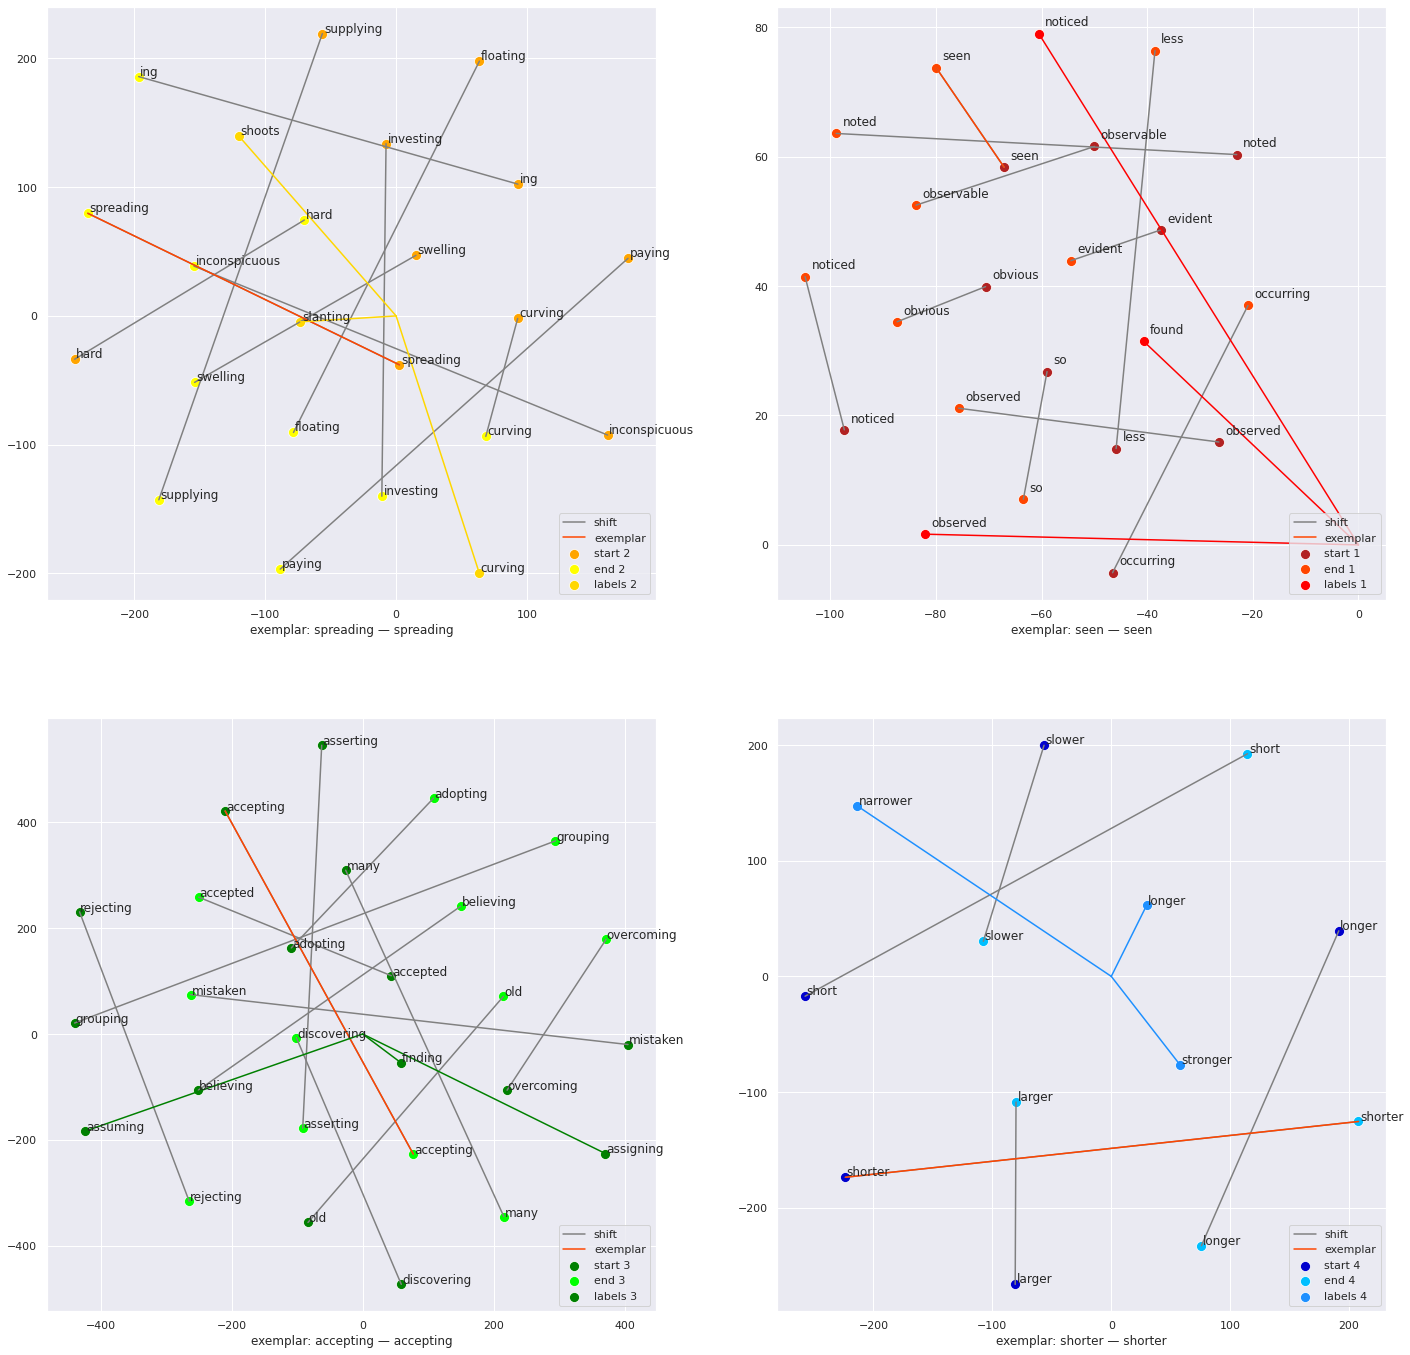

In [40]:
sns.set()
disp = 1.2 # displacement of point label in both directions

size_factor = 12

rows = 2
columns = 2
fig, axes = plt.subplots(rows, columns, figsize=(size_factor*columns, size_factor*rows))


visualize_cluster(t1, axes[0,1], xlabel=True, distance=(disp, disp), mono=tuples,
                  colors=("firebrick", "orangered", "red",      "orangered", "grey"), 
                  names= ("start 1",   "end 1",     "labels 1", "exemplar",  "shift"))

visualize_cluster(t2, axes[0,0], xlabel=True, distance=(disp, disp), mono=tuples,
                  colors=("orange",  "yellow", "gold",     "orangered", "grey"), 
                  names= ("start 2", "end 2",  "labels 2", "exemplar",  "shift"))

visualize_cluster(t3, axes[1,0], xlabel=True, distance=(disp, disp), mono=tuples,
                  colors=("green",   "lime",  "green",    "orangered", "grey"), 
                  names= ("start 3", "end 3", "labels 3", "exemplar",  "shift"))

visualize_cluster(t4, axes[1,1], xlabel=True, distance=(disp, disp), mono=tuples,
                  colors=("mediumblue", "deepskyblue", "dodgerblue", "orangered", "grey"), 
                  names= ("start 4",    "end 4",       "labels 4",   "exemplar",  "shift"))

In [69]:
outstring = "visuals/tsne/tsne_"+y[:-1]+"_"+e[:-1]+"_"\
             +str(i1)+"-"+str(i2)+"-"+str(i3)+"-"+str(i4)\
             +"_"+str(time.time())[-5:]+".png"
print(outstring)
#fig.savefig(outstring, dpi=250)

visuals/tsne/tsne_1860_1890_unsup_mono_724-763-739-759_54449.png
